## Notebook version of the submission

In [1]:
import folktables
from folktables import ACSDataSource
import numpy as np

from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing 

import pandas as pd

from sklearn.model_selection import train_test_split
import sklearn

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

In [24]:
# TODO: have it load data from file when False
GET_DATA = False

SENSITIVE_ATTRIBUTE = 'SEX'


#(Age) must be greater than 16 and less than 90, and (Person weight) must be greater than or equal to 1
def employment_filter(data):
    """
    Filters for the employment prediction task
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['AGEP'] < 90]
    df = df[df['PWGTP'] >= 1]
    return df

ACSEmployment = folktables.BasicProblem(
    features=[
    'AGEP', #age; for range of values of features please check Appendix B.4 of 
            #Retiring Adult: New Datasets for Fair Machine Learning NeurIPS 2021 paper
    'SCHL', #educational attainment
    'MAR', #marital status
    'RELP', #relationship
    'DIS', #disability recode
    'ESP', #employment status of parents
    'CIT', #citizenship status
    'MIG', #mobility status (lived here 1 year ago)
    'MIL', #military service
    'ANC', #ancestry recode
    'NATIVITY', #nativity
    'DEAR', #hearing difficulty
    'DEYE', #vision difficulty
    'DREM', #cognitive difficulty
    'SEX', #sex
    'RAC1P', #recoded detailed race code
    'GCL', #grandparents living with grandchildren
    ],
    target='ESR', #employment status recode
    target_transform=lambda x: x == 1,
    group=SENSITIVE_ATTRIBUTE, 
    preprocess=employment_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

if GET_DATA:
    data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=["CA"], download=True) #data for California state
else:
    data = pd.read_csv('data/2018/1-Year/psam_p06.csv')
    acs_data = data


features, label, group = ACSEmployment.df_to_numpy(acs_data)
data = pd.DataFrame(features, columns = ACSEmployment.features)
data['label'] = label

In [46]:
# Once the data is loaded, we need to partition it into train, validation, and test sets.
# We want 70/30 train/test split, and 20% of the training set to be used for validation.
# We want to randomly split the training set 5 times.
# We also want this data to be in the format that AIF360 expects, which should also handle preprocessing.

train, test = train_test_split(data, test_size=0.3, random_state=42)
train_val_splits = dict()
favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = np.array([[1]])
privileged_groups = [{'SEX': 1}]
unprivileged_groups = [{'SEX': 2}]

train_dataset = StandardDataset(train, 'label', favorable_classes = favorable_classes,
                        protected_attribute_names = protected_attribute_names,
                        privileged_classes = privileged_classes)

test = StandardDataset(test, 'label', favorable_classes = favorable_classes,
                        protected_attribute_names = protected_attribute_names,
                        privileged_classes = privileged_classes)

def get_train_val_splits(train, reweigh = False):
    for i in range(5):
        # Shuffle the training set
        train = sklearn.utils.shuffle(train)
        train_split, val_split = train_test_split(train, test_size=0.2, random_state=42)
        train_split = StandardDataset(train_split, 'label', favorable_classes = favorable_classes,
                                protected_attribute_names = protected_attribute_names,
                                privileged_classes = privileged_classes)
        val_split = StandardDataset(val_split, 'label', favorable_classes = favorable_classes,
                            protected_attribute_names = protected_attribute_names,
                            privileged_classes = privileged_classes)
        if reweigh:
            # Reweigh the training split
            RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
            RW.fit(train_split)
            train_split = RW.transform(train_split)
            
        train_val_splits[i] = (train_split, val_split)
    return train_val_splits

In [47]:
get_train_val_splits(train, reweigh=False)
print("phase 2")
get_train_val_splits(train, reweigh=True)

phase 2


{0: (               instance weights features                                       \
                                                                                  
                                      AGEP  SCHL  MAR  RELP  DIS  ESP  CIT  MIG   
  instance names                                                                  
  11258                  1.124064     21.0  16.0  5.0  17.0  2.0  0.0  1.0  1.0   
  218475                 1.086512     35.0  21.0  3.0   2.0  2.0  0.0  1.0  1.0   
  104999                 0.904390     40.0   9.0  4.0  15.0  2.0  0.0  5.0  1.0   
  93700                  0.923251     45.0  16.0  1.0   1.0  2.0  0.0  1.0  1.0   
  90390                  1.086512     55.0  16.0  3.0   2.0  2.0  0.0  1.0  1.0   
  ...                         ...      ...   ...  ...   ...  ...  ...  ...  ...   
  9716                   1.124064     64.0  18.0  5.0  17.0  1.0  0.0  1.0  1.0   
  166177                 0.923251     58.0  21.0  1.0   0.0  2.0  0.0  4.0  1.0   
 

In [57]:
def hyperparameter_tuning(train_dataset, train_val_splits, unprivileged_groups, privileged_groups, reweighing = False):
    hyperparameters = { 'C': [1e-7, 1e-6, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
    averaged_results = dict()
    # Perform a grid search over the hyperparameters (Can change this later)
    for C in hyperparameters['C']:
        # Train a model on each of the 5 train/val splits
        val_accuracies = []
        val_aif360_metrics = []
        for i in range(5):
            train_train = train_val_splits[i][0]
            train_val = train_val_splits[i][1]
            model = sklearn.linear_model.LogisticRegression(C=C, solver='liblinear')
            if reweighing == True:
                model.fit(train_train.features, train_train.labels.ravel(), sample_weight=train_train.instance_weights.ravel())
            else:
                model.fit(train_train.features, train_train.labels.ravel())

            # Evaluate the model on the validation set
            val_predictions = train_val.copy()
            val_predictions.labels = model.predict(train_val.features)
            val_accuracy = sklearn.metrics.accuracy_score(train_val.labels, val_predictions.labels)
            metric = ClassificationMetric(train_val, val_predictions, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
            metric_arrs = {}
            #Statistical Parity Difference measures the difference of the above values instead of ratios, hence we
            #would like it to be close to 0.
            metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
            val_accuracies.append(val_accuracy)
            val_aif360_metrics.append(metric_arrs['stat_par_diff'])
        
        # Average the results of the 5 train/val splits
        val_accuracy = np.mean(val_accuracies)
        val_aif360_metric = np.mean(val_aif360_metrics)
        print("C: ", C)
        print("Validation Accuracy: ", val_accuracy)
        print("Validation Statistical Parity Difference: ", val_aif360_metric)
        averaged_results[C] = (val_accuracy, val_aif360_metric)

    # Choose the best hyperparameter for accuracy
    accurate_C = max(averaged_results, key=lambda x: averaged_results[x][0])
    stat_par_diff_C = max(averaged_results, key=lambda x: averaged_results[x][1])
    print("Best C for accuracy: ", accurate_C)
    print("Best C for Statistical Parity Difference: ", stat_par_diff_C)

    # train a model on the entire training set using the best hyperparameter
    if reweighing == True:
        # TODO: check this is working as expected when testing using reweighing (I'd guess it is but unsure)
        accurate_model = sklearn.linear_model.LogisticRegression(C=accurate_C, solver='liblinear')
        accurate_model.fit(train_dataset.features, train_dataset.labels.ravel(), sample_weight=train_dataset.instance_weights.ravel())
        fair_model = sklearn.linear_model.LogisticRegression(C=stat_par_diff_C, solver='liblinear')
        fair_model.fit(train_dataset.features, train_dataset.labels.ravel(), sample_weight=train_dataset.instance_weights.ravel())
    else:
        accurate_model = sklearn.linear_model.LogisticRegression(C=accurate_C, solver='liblinear')
        accurate_model.fit(train_dataset.features, train_dataset.labels.ravel())
        fair_model = sklearn.linear_model.LogisticRegression(C=stat_par_diff_C, solver='liblinear')
        fair_model.fit(train_dataset.features, train_dataset.labels.ravel())
    return accurate_model, fair_model, averaged_results

In [55]:
# Evaluate the model on the test set
def evaluate_model(model):

    test_predictions = test.copy()
    test_predictions.labels = model.predict(test.features)
    test_accuracy = sklearn.metrics.accuracy_score(test.labels, test_predictions.labels)
    metric = ClassificationMetric(test, test_predictions, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    metric_arrs = {}
    #Statistical Parity Difference measures the difference of the above values instead of ratios, hence we
    #would like it to be close to 0.
    metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
    return test_accuracy, metric_arrs

In [58]:
train_val_splits_orig = get_train_val_splits(train, reweigh = False)

model_1, model_2, averaged_results = hyperparameter_tuning(train_dataset, train_val_splits_orig, unprivileged_groups, privileged_groups, reweighing = False)

model_1_scores = evaluate_model(model_1)
model_2_scores = evaluate_model(model_2)
print("Model 1 Accuracy: ", model_1_scores[0])
print("Model 1 Statistical Parity Difference: ", model_1_scores[1]['stat_par_diff'])
print("Model 2 Accuracy: ", model_2_scores[0])
print("Model 2 Statistical Parity Difference: ", model_2_scores[1]['stat_par_diff'])

C:  1e-07
Validation Accuracy:  0.6340712768468255
Validation Statistical Parity Difference:  -0.0249140221061954
C:  1e-06
Validation Accuracy:  0.6901486901109275
Validation Statistical Parity Difference:  -0.014236932128998125
C:  1e-05
Validation Accuracy:  0.703922586735898
Validation Statistical Parity Difference:  -0.009211599263603066
C:  0.0001
Validation Accuracy:  0.7203445834316733
Validation Statistical Parity Difference:  -0.08130727207597169
C:  0.001
Validation Accuracy:  0.7257115883880104
Validation Statistical Parity Difference:  -0.14690075676241415
C:  0.01
Validation Accuracy:  0.7287703563842342
Validation Statistical Parity Difference:  -0.14913553498213222
C:  0.1
Validation Accuracy:  0.7286240264337975
Validation Statistical Parity Difference:  -0.14666338702827397
C:  1
Validation Accuracy:  0.7283596884588152
Validation Statistical Parity Difference:  -0.14567681874938837
C:  10
Validation Accuracy:  0.7283785697427424
Validation Statistical Parity Differen

In [59]:
import matplotlib.pyplot as plt

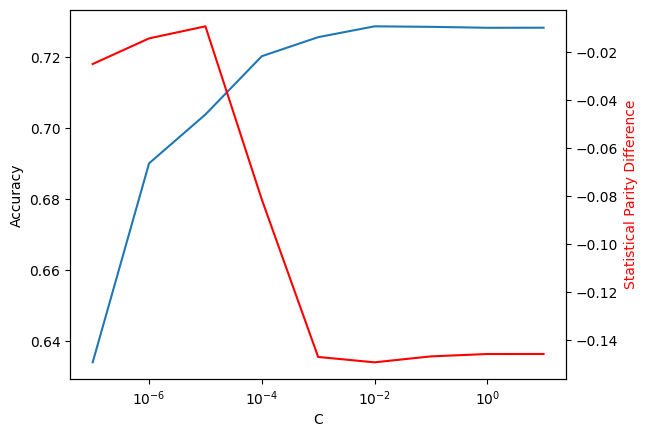

In [66]:
def plot_results(results):
    # Plot the averaged results of the 5 train/val splits
    values = results.values()
    accuracies = [x[0] for x in values]
    stat_par_diffs = [x[1] for x in values]
    C_values = results.keys()
    # Plot the accuracies on one axis and the statistical parity differences on another
    ax1 = plt.gca()
    ax1.plot(C_values, accuracies)
    ax1.set_xlabel('C')
    ax1.set_xscale('log')
    ax1.set_ylabel('Accuracy')

    # Plot the statistical parity differences on the same axis
    ax2 = ax1.twinx()
    ax2.plot(C_values, stat_par_diffs, color='r')
    ax2.set_ylabel('Statistical Parity Difference', color='r')
    plt.show()

plot_results(averaged_results)

In [61]:
# Task 2:
# This looks very similar to before, but first using some fairness-aware method.
# Will start with the simplest one: Reweighing


# First, we will reweigh the training set
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(train_dataset)
train_dataset_reweighed = RW.transform(train_dataset)


train_val_splits_reweighed = get_train_val_splits(train, reweigh = True)


# Perform hyperparameter tuning and evaluation as before
model_3, model_4, reweighed_average_results = hyperparameter_tuning(train_dataset_reweighed, train_val_splits_reweighed, unprivileged_groups, privileged_groups, reweighing = True)

model_3_scores = evaluate_model(model_3)
model_4_scores = evaluate_model(model_4)
print("Model 3 Accuracy: ", model_3_scores[0])
print("Model 3 Statistical Parity Difference: ", model_3_scores[1]['stat_par_diff'])
print("Model 4 Accuracy: ", model_4_scores[0])
print("Model 4 Statistical Parity Difference: ", model_4_scores[1]['stat_par_diff'])


C:  1e-07
Validation Accuracy:  0.6326787821571866
Validation Statistical Parity Difference:  -0.020581736015704188
C:  1e-06
Validation Accuracy:  0.6888175595940524
Validation Statistical Parity Difference:  -0.006822719716852532
C:  1e-05
Validation Accuracy:  0.7022657540712769
Validation Statistical Parity Difference:  0.010811407216276648
C:  0.0001
Validation Accuracy:  0.7190087325938164
Validation Statistical Parity Difference:  -0.01549201197253558
C:  0.001
Validation Accuracy:  0.7270899221147038
Validation Statistical Parity Difference:  -0.04311817221976224
C:  0.01
Validation Accuracy:  0.7286665093226339
Validation Statistical Parity Difference:  -0.0404237839967305
C:  0.1
Validation Accuracy:  0.7280575879159784
Validation Statistical Parity Difference:  -0.03634464564808828
C:  1
Validation Accuracy:  0.7279065376445598
Validation Statistical Parity Difference:  -0.03551387232873478
C:  10
Validation Accuracy:  0.7278498937927779
Validation Statistical Parity Differe

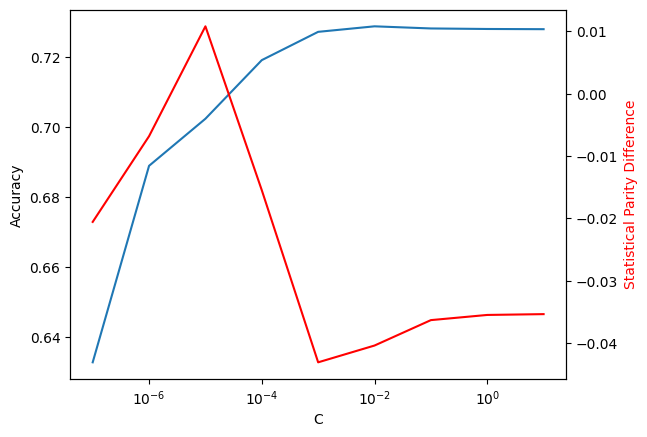

In [67]:
plot_results(reweighed_average_results)